# Traffic to a web page - Predict next 7 days

## Seasonality version

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
from datetime import timedelta
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
#set default figure size
plt.rcParams["figure.figsize"] = (12,8);

In [3]:
visits = pd.read_csv('prospect.csv',names=['date', 'number_of_visits'],skiprows=1)
visits

,date,number_of_visits
0,01/04/2022,1078046
1,02/04/2022,845353
2,03/04/2022,835836
3,04/04/2022,1325665
4,05/04/2022,1168638
...,...,...
197,15/10/2022,870042
198,16/10/2022,774887
199,17/10/2022,1302557
200,18/10/2022,1298162


In [4]:
# Converting date to a datetime object with a specific format, because it looks cleaner
visits['date'] = pd.to_datetime(visits['date'], utc=True, dayfirst=True ).dt.date

In [5]:
visits.index= visits['date']
del visits['date']

In [6]:
visits.head()

,number_of_visits
date,
2022-04-01,1078046
2022-04-02,845353
2022-04-03,835836
2022-04-04,1325665
2022-04-05,1168638


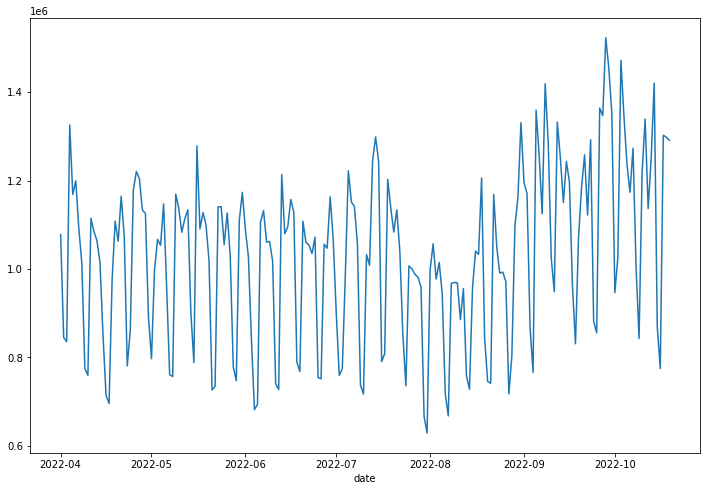

In [165]:
# Checking if the data is homoskedastic, 
visits.number_of_visits.plot();

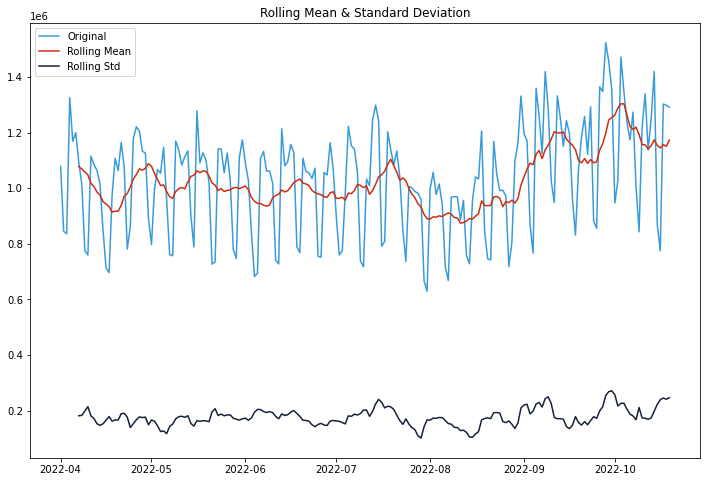

In [166]:
visits["rolling_avg"] = visits["number_of_visits"].rolling(window=7).mean()
visits["rolling_std"] = visits["number_of_visits"].rolling(window=7).std()

plt.plot(visits["number_of_visits"], color='#379BDB', label='Original')
plt.plot(visits["rolling_avg"] , color='#D22A0D', label='Rolling Mean')
plt.plot(visits["rolling_std"], color='#142039', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation');

In [167]:
visits.drop("rolling_avg", axis=1, inplace= True)
visits.drop("rolling_std", axis=1, inplace=True)

## Check for seasonality

In [11]:
# Finding the p, d, q values in ARIMA model
# p is the number of autoregressive terms,
# d is the number of nonseasonal differences,
# q is the number of lagged forecast errors in the prediction equation.

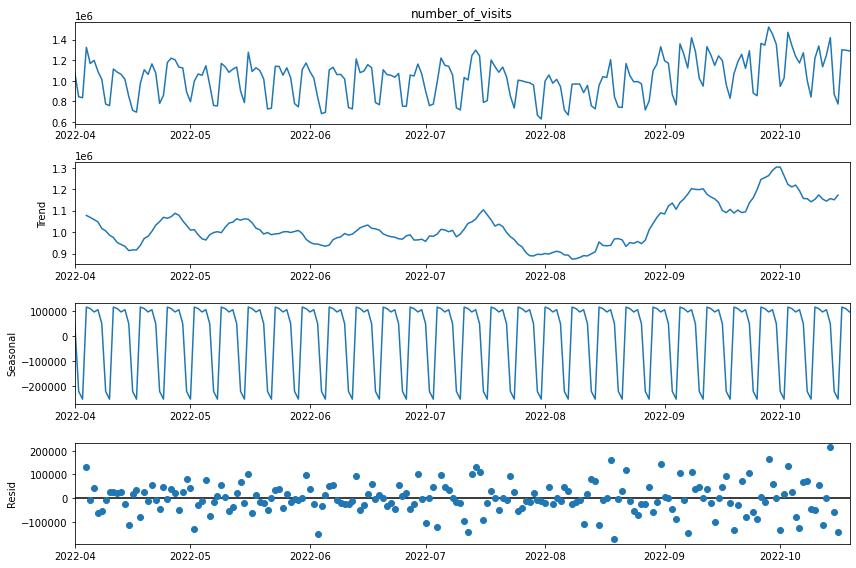

In [168]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(visits.number_of_visits, period=7)
decomp.plot();

In [502]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
   dftest = adfuller(dataset, autolag = 'AIC')
   print("1. ADF : ",dftest[0])
   print("2. P-Value : ", dftest[1])
   print("3. Num Of Lags : ", dftest[2])
   print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
   print("5. Critical Values :")
   for key, val in dftest[4].items():
        print("\t",key, ": ", val)

   if dftest[1] <= 0.05:
        print("Data is stationary")
   else:
        print("data is not stationary")   

adf_test(visits.number_of_visits) 
print("___________________________")       
adf_test(visits.number_of_visits.diff().dropna()) 
print("___________________________")



1. ADF :  -2.239213170498746
2. P-Value :  0.1923222944887557
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 31
5. Critical Values :
	 1% :  -3.661428725118324
	 5% :  -2.960525341210433
	 10% :  -2.6193188033298647
data is not stationary
___________________________
1. ADF :  -6.91358718418572
2. P-Value :  1.1950818995098446e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 188
5. Critical Values :
	 1% :  -3.465620397124192
	 5% :  -2.8770397560752436
	 10% :  -2.5750324547306476
Data is stationary
___________________________


In [170]:
# Test for stationarity
# P-VALUE FOR THE DATA AS IT IS SHOWS THAT IT IS NO STATIONARY AND NEEDS DIFFERENTISTION

#Default HIGH p value
res = adfuller(visits.number_of_visits)
print(f'p value = {res[1]}')


# first order diff

res = adfuller(visits.number_of_visits.diff(7).dropna())
print(f'p value = {res[1]}')


p value = 0.7192942795025312
p value = 0.004707026260892758


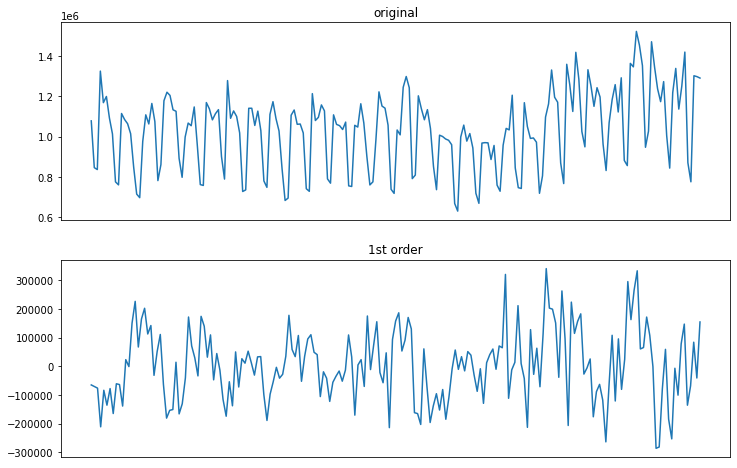

In [269]:
fig, (ax,ax1) = plt.subplots(2)
first_order = visits.number_of_visits.diff(7).dropna()
ax.plot(visits.number_of_visits);ax.set_title('original'); ax.axes.xaxis.set_visible(False)
ax1.plot(first_order);ax1.set_title('1st order'); ax1.axes.xaxis.set_visible(False)

# Modeling using SARIMA

In [174]:
import pmdarima as pm

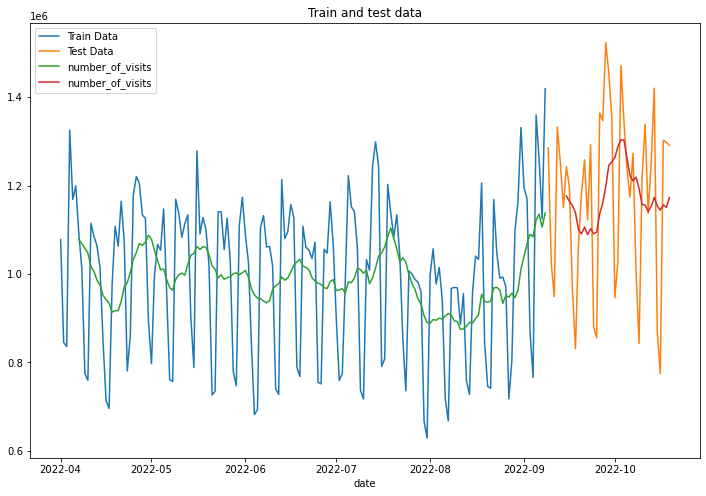

In [498]:

train_size = int(0.80*len(visits))
train = visits.number_of_visits.iloc[:train_size]

test = visits.number_of_visits.iloc[train_size:]

fig, ax = plt.subplots(1, 1)
train.plot(ax=ax, label='Train Data')
test.plot(ax=ax, label='Test Data')
ax.set_title("Train and test data")


# Train Mean
train = train.to_frame()
train.number_of_visits.rolling(window=7).mean().plot()


# Test Mean
test = test.to_frame()
test.number_of_visits.rolling(window=7).mean().plot()

ax.legend(loc='upper left');

In [499]:
#train = train.to_frame()
pm.auto_arima(train.values, m=7, seasonal=True, test='adf',error_action='ignore',  
                           suppress_warnings=True,stepwise=True, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4223.167, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4347.073, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4267.673, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4257.655, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4910.687, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4258.377, Time=0.17 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4220.472, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=4303.527, Time=0.10 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4220.485, Time=0.32 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=4218.199, Time=0.55 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=4222.368, Time=1.21 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=4211.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  161
Model:             SARIMAX(4, 0, 2)x(2, 0, [], 7)   Log Likelihood               -2084.527
Date:                            Sun, 23 Oct 2022   AIC                           4189.054
Time:                                    02:17:16   BIC                           4219.868
Sample:                                         0   HQIC                          4201.566
                                            - 161                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.031e+05   2.86e+05      2.108      0.035    4.24e+04    1.16e+06
ar.L1         -1.3408      0.179     -7.505      0.000      -1.691      -0.991
ar.L2         -0.4364      0.225     -1.943      0.052      -0.877       0.004
ar.L3          0.3135      0.211      1.486      0.137      -0.100       0.727
ar.L4          0.0940      0.147      0.639      0.523      -0.194       0.382
ma.L1          1.7034      0.074     22.973      0.000       1.558       1.849
ma.L2          0.9646      0.070     13.774      0.000       0.827       1.102
ar.S.L7        0.4607      0.156      2.946      0.003       0.154       0.767
ar.S.L14       0.2959      0.157      1.888      0.059      -0.011       0.603
sigma2      1.483e+10      4.723   3.14e+09      0.000    1.48e+10    1.48e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):                19.61
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.79
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.3e+25. Standard errors may be unstable.
"""

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarim

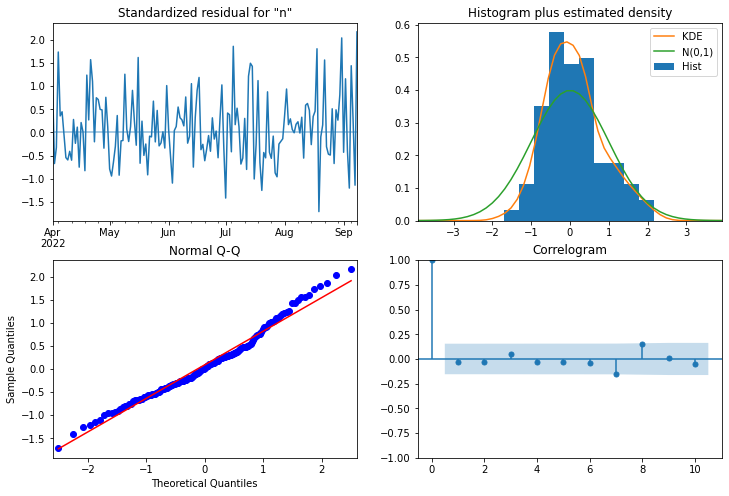

In [500]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
seasonal_model = SARIMAX(train, order=(4,0,2), seasonal_order=(2,0,0,7) ).fit()
seasonal_model.plot_diagnostics();

In [495]:
seasonal_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   number_of_visits   No. Observations:                  171
Model:             SARIMAX(4, 0, 2)x(2, 0, [], 7)   Log Likelihood               -2219.202
Date:                            Sun, 23 Oct 2022   AIC                           4456.403
Time:                                    02:15:41   BIC                           4484.678
Sample:                                04-01-2022   HQIC                          4467.876
                                     - 09-18-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2152     10.170      0.021      0.983     -19.717      20.148
ar.L2          0.8730     11.446      0.076      0.939     -21.561      23.307
ar.L3         -0.1281      1.288     -0.099      0.921      -2.653       2.397
ar.L4         -0.0176      0.408     -0.043      0.966      -0.817       0.782
ma.L1          0.2293     10.175      0.023      0.982     -19.714      20.173
ma.L2         -0.5938      6.930     -0.086      0.932     -14.176      12.988
ar.S.L7        0.4443      0.128      3.481      0.000       0.194       0.695
ar.S.L14       0.4602      0.133      3.459      0.001       0.199       0.721
sigma2      1.625e+10   2.28e-09   7.12e+18      0.000    1.63e+10    1.63e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 8.09
Prob(Q):                              0.69   Prob(JB):                         0.02
Heteroskedasticity (H):               1.33   Skew:                             0.52
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.76e+35. Standard errors may be unstable.
"""

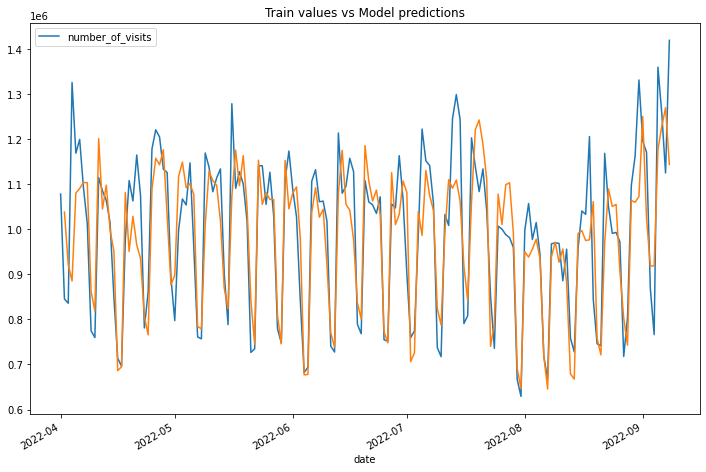

In [503]:
# Train values predictions
fig, ax = plt.subplots(1, 1)
train.plot(ax=ax,label='Actual')
seasonal_model.predict(start=train.index[1],dynamic=False).plot(ax=ax, label='Model predictions')
ax.set_title("Train values vs Model predictions");

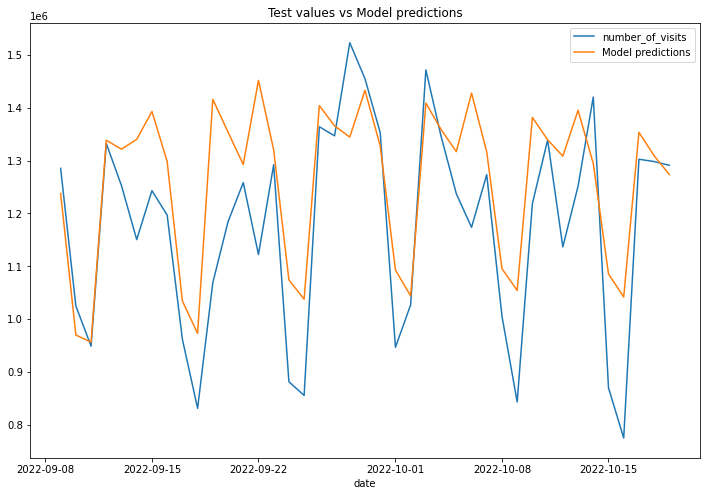

In [504]:
# FORCASTING TEST BASED ON TRAIN

# Test value prediction
pred = seasonal_model.get_forecast(len(test))
pred.conf_int()

pred_df = pred.conf_int(alpha = 0.1)
pred_df["Predictions"] = seasonal_model.predict(start = pred_df.index[0], end = pred_df.index[-1], dynamic=False)
pred_df.index = test.index
pred_out = pred_df["Predictions"] 


fig, ax = plt.subplots(1, 1)
test.plot(ax=ax, label="Test values")
pred_out.plot(ax=ax,label='Model predictions')
ax.set_title("Test values vs Model predictions")
ax.legend();


In [505]:
model_msre = np.sqrt(mean_squared_error(test.values, pred_df.Predictions))
print("Test Model RMSE: ",model_msre)

Test Model RMSE:  142595.5139164111


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarim

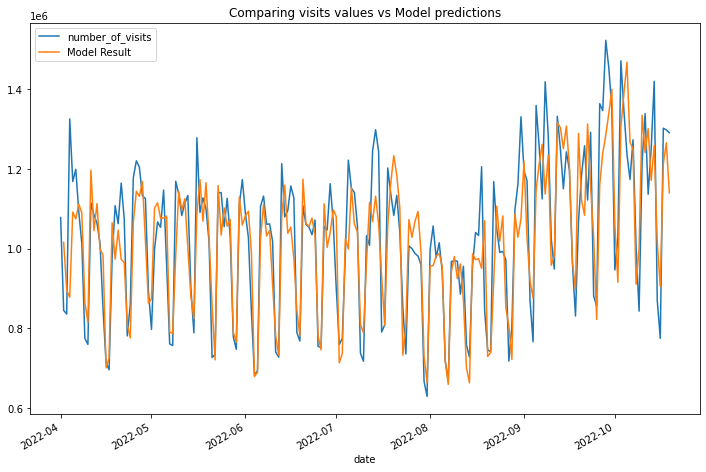

In [506]:
predict_model = SARIMAX(visits, order=(4,0,2), seasonal_order=(2,0,0,7)).fit()

#SARIMAX(visits, order=(3,1,3), seasonal_order=(1,0,1,7)).fit() 82%
#SARIMAX(visits, order=(2,1,2), seasonal_order=(1,0,1,7)).fit() 81% test
#SARIMAX(visits, order=(4,0,2), seasonal_order=(2,0,0,7)).fit() 80% test

pred = predict_model.get_forecast(len(visits))
pred.conf_int()


pred_df = pred.conf_int(alpha = 0.1)
pred_df["Predictions"] = predict_model.predict(start = pred_df.index[0], end = pred_df.index[-1], dynamic=False)
pred_df.index = visits.index
pred_out = pred_df["Predictions"] 


fig, ax = plt.subplots(1, 1)
visits.plot(ax=ax, label="Actual Number of visits")
predict_model.predict(start=train.index[1], dynamic=False).plot(ax=ax, label='Model Result')
ax.set_title("Comparing visits values vs Model predictions")
ax.legend();


In [507]:
predict_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   number_of_visits   No. Observations:                  202
Model:             SARIMAX(4, 0, 2)x(2, 0, [], 7)   Log Likelihood               -2636.048
Date:                            Sun, 23 Oct 2022   AIC                           5290.097
Time:                                    02:20:48   BIC                           5319.871
Sample:                                04-01-2022   HQIC                          5302.144
                                     - 10-19-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7702      0.753      1.023      0.306      -0.705       2.246
ar.L2          0.5058      0.923      0.548      0.584      -1.304       2.316
ar.L3         -0.1266      0.279     -0.454      0.650      -0.673       0.420
ar.L4         -0.1598      0.143     -1.117      0.264      -0.440       0.121
ma.L1         -0.3103      0.748     -0.415      0.678      -1.777       1.156
ma.L2         -0.5596      0.584     -0.959      0.338      -1.704       0.584
ar.S.L7        0.4984      0.122      4.097      0.000       0.260       0.737
ar.S.L14       0.3791      0.122      3.120      0.002       0.141       0.617
sigma2      1.849e+10   1.24e-11   1.49e+21      0.000    1.85e+10    1.85e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 2.86
Prob(Q):                              0.47   Prob(JB):                         0.24
Heteroskedasticity (H):               2.26   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+38. Standard errors may be unstable.
"""

In [508]:

model_msre = np.sqrt(mean_squared_error(visits.number_of_visits, pred_df.Predictions))
print("Final Model RMSE: ",model_msre)

Final Model RMSE:  528490.4155409875


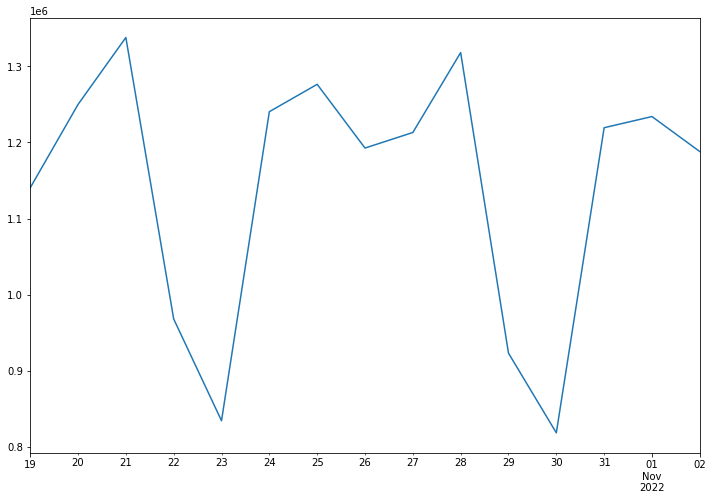

In [511]:
def prospect_forcasts(days, all=False):
    start_date = visits.index[-1]
    end_date = visits.index[-1] + timedelta(days=days)
    df = predict_model.predict(start=start_date, end=end_date)

    if all:
        visits.plot(label="Actual Number of visits")
        df.plot()
    else:    
        df.plot()

prospect_forcasts(14,1)